This notebook aims to experiment loading of saved models. The saved models used here is from notebook 12_custom_models_and_training.ipynb


### Importing libraries

In [51]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## to make the notebook output stable
np.random.seed(42)
tf.random.set_seed(42)

### Dataset for our experiment

In [2]:
X, y = fetch_california_housing(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

## Custom LOSS

The three case dealt here are:
 - model that was compiled with a custom loss function (testing .keras and .h5 format)
 - model that was compile with a paremeterized custom loss function (testing .h5 format)
 - model that was compiled with custom loss subclasssed (testing .keras, .h5, savedModel format)

####1. Loading a saved model that used a custom loss function

Test saved model `(.keras)` that used custom loss function

In [44]:
model_custom_loss_function_dot_keras = tf.keras.models.load_model('/content/my_model_custom_loss_huber.keras')
model_custom_loss_function_dot_keras.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.1980 - mae: 0.4882 - mse: 0.4682


[0.19795940816402435, 0.48822590708732605, 0.4682220220565796]

Test saved model`(.h5)` that used custom loss function

In [45]:
model_custom_loss_function = tf.keras.models.load_model('/content/my_model_custom_loss_huber.h5')

In [46]:
model_custom_loss_function.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.1980 - mae: 0.4882 - mse: 0.4682


[0.19795940816402435, 0.48822590708732605, 0.4682220220565796]

Test saved model (SavedModel format) that used custom loss function

In [47]:
#load model and try evaluation
model_saveModelformat = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/HML/my_model_custom_loss_huber')
model_saveModelformat.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.1980 - mae: 0.4882 - mse: 0.4682


[0.19795940816402435, 0.48822590708732605, 0.4682220220565796]

Look like we don't need to specify custom_object when loading model using a custom loss function

#### 2. Loading a saved model (.h5) that used parameterized custom loss function

In [48]:
model_custom_loss_function_parameterized = tf.keras.models.load_model('/content/my_model_custom_loss_parameterized.h5')
model_custom_loss_function_parameterized.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 2ms/step - loss: 0.1916 - mae: 0.4829


[0.19164715707302094, 0.4828616976737976]

In [49]:
model_custom_loss_function_parameterized.get_compile_config()

{'optimizer': {'module': 'keras.optimizers.experimental',
  'class_name': 'Nadam',
  'config': {'name': 'Nadam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'function',
  'config': 'huber',
  'registered_name': 'huber'},
 'metrics': [[{'module': 'keras.metrics',
    'class_name': 'MeanMetricWrapper',
    'config': {'name': 'mae',
     'dtype': 'float32',
     'fn': {'module': 'keras.losses',
      'class_name': 'function',
      'config': 'mean_absolute_error',
      'registered_name': 'mean_absolute_error'}},
    'registered_name': None}]],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'ste

Lets try loading the model with custom function object specified. For this you need the custom function available in the session

In [9]:
# define huber loss

def huber_loss(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss = tf.square(error) / 2
  linear_loss = tf.abs(error) - 0.5

  return tf.where(is_small_error, squared_loss, linear_loss)

In [21]:
model_custom_loss_function_dot_keras_custom_object = tf.keras.models.load_model('/content/my_model_custom_loss_huber.keras',
                                                                                custom_objects={'huber_loss': huber_loss})

In [22]:
model_custom_loss_function_dot_keras_custom_object.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.1980 - mae: 0.4882 - mse: 0.4682


[0.19795940816402435, 0.48822590708732605, 0.4682220220565796]

So that also works, but seems that we need to track of an additional step of having the custom function available for the model to load with custom objects

####3. Loading a saved model that used a subclassed loss function

Test saved model `(.keras)` that used custom loss subclassed

In [12]:
model_custom_loss_subclassed_dot_keras = tf.keras.models.load_model('/content/my_model_custom_loss_subclassed.keras')

ValueError: ignored

It is must to load model with custom objects specified, the reason being `.keras/HDF5` formats uses object `configs` to save the model architecture

In [13]:
model_customloss_subclassed_dotkeras = tf.keras.models.load_model('my_model_custom_loss_subclassed.keras',
                                                               custom_objects={'HuberLoss':HuberLoss})

NameError: ignored

subclassed code should be available

In [15]:
from tensorflow import keras
class HuberLoss(keras.losses.Loss):

    def __init__(self, threshold=1.0, **kwargs):
        self.threshold=threshold
        super().__init__(**kwargs)
    ##call(): Contains the logic for loss calculation using y_true, y_pred
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = error < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold':self.threshold}

In [30]:
model_customloss_subclassed_dotkeras = tf.keras.models.load_model('my_model_custom_loss_subclassed.keras',
                                                               custom_objects={'HuberLoss':HuberLoss})

In [31]:
model_customloss_subclassed_dotkeras.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 2ms/step - loss: 0.2398 - mae: 0.5181


[0.23983554542064667, 0.5180786848068237]

In [24]:
model_customloss_subclassed_dotkeras.get_config() # model configuration

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_2_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 8),
    'units': 32,
    'activation': 'selu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'LecunNormal',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_3',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_ini

model compile configuration. Note the **loss object, its config**

In [26]:
model_customloss_subclassed_dotkeras.get_compile_config()

{'optimizer': {'module': 'keras.optimizers.experimental',
  'class_name': 'Nadam',
  'config': {'name': 'Nadam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07},
  'registered_name': None},
 'loss': {'module': '__main__',
  'class_name': 'HuberLoss',
  'config': {'reduction': 'auto', 'name': None, 'threshold': 2.0},
  'registered_name': 'HuberLoss'},
 'metrics': [[{'module': 'keras.metrics',
    'class_name': 'MeanMetricWrapper',
    'config': {'name': 'mae',
     'dtype': 'float32',
     'fn': {'module': 'keras.losses',
      'class_name': 'function',
      'config': 'mean_absolute_error',
      'registered_name': 'mean_absolute_error'}},
    'registered_name': None}]],
 'loss_weights': None,
 'weigh

In [43]:
# get the threshold attribute
model_customloss_subclassed_dotkeras.loss.threshold

2.0

.h5

In [28]:
model_customloss_subclassed_h5 = tf.keras.models.load_model('/content/my_model_custom_loss_subclassed.h5',
                                                               custom_objects={'HuberLoss':HuberLoss})

In [29]:
model_customloss_subclassed_h5.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.2398 - mae: 0.5181


[0.23983554542064667, 0.5180786848068237]

In [42]:
model_customloss_subclassed_h5.loss.threshold

2.0

SavedModel

In [34]:
model_customloss_subclassed_savedModel = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/HML/my_model_custom_loss_subclassed',
                                                                 custom_objects={'HuberLoss':HuberLoss})

In [35]:
model_customloss_subclassed_savedModel.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2398 - mae: 0.5181


[0.23983554542064667, 0.5180786848068237]

In [38]:
model_customloss_subclassed_savedModel.fit(X_train_scaled, y_train,
                                           epochs=2,
                                           validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 2ms/step - loss: 0.2348 - mae: 0.5069 - val_loss: 0.2404 - val_mae: 0.4929
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2232 - mae: 0.4934 - val_loss: 0.2614 - val_mae: 0.4852


In [41]:
model_customloss_subclassed_savedModel.loss.threshold

2.0

## Other Custom Functions
Custom Activation Functions, Initializers, Regularizers, and Constraints

#### 1. as custom functions added to the model layer

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
## define custom functions
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

[]

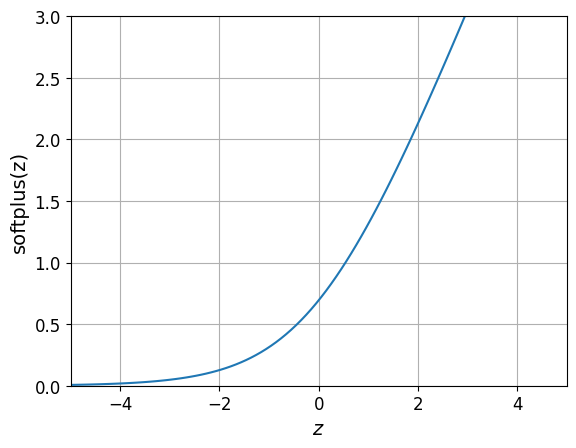

In [ ]:
z = np.linspace(-5, 5, 100)
f_z = my_softplus(z)

plt.plot(z, f_z)
plt.axis([-5, 5, 0, 3])
plt.ylabel('softplus(z)')
plt.xlabel('$z$')
plt.grid()
plt.plot()

In [ ]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
# zeros_like function will make all 0
tf.zeros_like([1,1,1])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>

In [ ]:
# Define layer with custom function
myDenselayer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal', input_shape=input_shape),
      tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)
])

In [ ]:
model.compile(loss="mse", optimizer='nadam', metrics=['mae'])

In [ ]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.9595 - mae: 0.9574 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6103 - mae: 0.5229 - val_loss: inf - val_mae: inf


In [ ]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 1.8900 - mae: 0.5403


[1.8900423049926758, 0.5402973890304565]

In [ ]:
model.save('model_layer_custom_fn.keras')
model.save('model_layer_custom_fn.h5')
model.save('model_layer_custom_fn')

In [ ]:
!cp -r  'model_layer_custom_fn' '/content/drive/MyDrive/ColabNotebooks/HML'

In [ ]:
model_layer_custom_fn_dotkeras = tf.keras.models.load_model('model_layer_custom_fn.keras')

TypeError: ignored

We observe that model loading failed due to unknown functions. So defining custom_objects is must when it comes to custom function used in model layers

In [ ]:
model_layer_custom_fn_dotkeras = keras.models.load_model(
    "model_layer_custom_fn.keras",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
model_layer_custom_fn_dotkeras.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 1.8900 - mae: 0.5403


[1.8900423049926758, 0.5402973890304565]

####2. Subclassing

If a function has hyperparameters that need to be saved along with the model, then you will want to subclass the appropriate class, such as keras.regularizers.Regularizer, keras.constraints.Constraint, keras.initializers.Initializer, or keras.layers.Layer (for any layer, including activation functions)

In [ ]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor=factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {'factor':self.factor}

Note that you must implement the call() method for losses, layers (including activation functions), and models, or the ```__call__()``` method for regularizers, initializers, and constraints.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal', input_shape=input_shape),
      tf.keras.layers.Dense(1, activation=my_softplus,
                            kernel_initializer=my_glorot_initializer,
                            kernel_regularizer=MyL1Regularizer(0.01),
                            kernel_constraint=my_positive_weights)
])

In [ ]:
model.compile(loss='mse', optimizer='nadam', metrics=['mae'])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.5385 - mae: 0.5076 - val_loss: 1.8651 - val_mae: 0.5095
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.5074 - mae: 0.4947 - val_loss: 1.5077 - val_mae: 0.5007


In [ ]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.4985 - mae: 0.4894


[0.4984534978866577, 0.4893927574157715]

In [ ]:
model.save("my_model_layer_with_custom_fns_subclass.keras")
model.save("my_model_layer_with_custom_fns_subclass.h5")
model.save("my_model_layer_with_custom_fns_subclass")

In [ ]:
!cp -r 'my_model_layer_with_custom_fns_subclass' '/content/drive/MyDrive/ColabNotebooks/HML'

In [ ]:
my_model_layer_with_custom_fns_subclass_dot_keras = tf.keras.models.load_model("my_model_layer_with_custom_fns_subclass.keras",
                                                                               custom_objects={"MyL1Regularizer": MyL1Regularizer,
                                                                                               "my_positive_weights": my_positive_weights,
                                                                                               "my_glorot_initializer": my_glorot_initializer,
                                                                                               "my_softplus": my_softplus})

In [ ]:
my_model_layer_with_custom_fns_subclass_dot_keras.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.4985 - mae: 0.4894


[0.4984534978866577, 0.4893927574157715]

## Custom Metrics

Losses and metrics are conceptually not the same thing: losses (e.g., cross entropy) are used by Gradient Descent to train a model, so they must be differentiable (at least where they are evaluated), and their gradients should not be 0 everywhere. It’s OK if they are not easily interpretable by humans.

In contrast, metrics (e.g., accuracy) are used to evaluate a model: they must be more easily interpretable, and they can be non-differentiable or have 0 gradients everywhere.

In most cases, defining a custom metric function is exactly the same as defining a custom loss function.

In [52]:
def create_huber(threshold=1.0):
    def huber_loss(y_true, y_pred):
        error= y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2

        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_loss

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal', input_shape=input_shape),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.9318 - huber_loss: 0.8119
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5090 - huber_loss: 0.2382


In [ ]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.4697 - huber_loss: 0.2294


[0.4696834683418274, 0.22937245666980743]

In [ ]:
model.save('model_custom_metric_fn.keras')
model.save('model_custom_metric_fn.h5')
model.save('model_custom_metric_fn')

In [ ]:
!cp -r 'model_custom_metric_fn' '/content/drive/MyDrive/ColabNotebooks/HML'

.keras

In [ ]:
model_custom_metric_fn_dot_keras = tf.keras.models.load_model('model_custom_metric_fn.keras')

ValueError: ignored

In [ ]:
model_custom_metric_fn_dot_keras = tf.keras.models.load_model('model_custom_metric_fn.keras',
                                                              custom_objects={'huber_loss':create_huber(2.0)})
model_custom_metric_fn_dot_keras.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 5ms/step - loss: 0.4697 - huber_loss: 0.2294


[0.4696834683418274, 0.22937245666980743]

.h5

In [ ]:
model_custom_metric_fn_h5 = tf.keras.models.load_model('model_custom_metric_fn.h5',
                                                              custom_objects={'huber_loss':create_huber(2.0)})
model_custom_metric_fn_h5.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.4697 - huber_loss: 0.2294


[0.4696834683418274, 0.22937245666980743]

SavedModel

In [ ]:
model_custom_metric_fn = tf.keras.models.load_model('model_custom_metric_fn',
                                                              custom_objects={'huber_loss':create_huber(2.0)})
model_custom_metric_fn.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 2s 10ms/step - loss: 0.4697 - huber_loss: 0.2294


[0.4696834683418274, 0.22937245666980743]

**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [ ]:
model.compile(loss=create_huber(2.0),
              optimizer='nadam',
              metrics=[create_huber(2.0)])

In [ ]:
sample_weight=np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.1127 - huber_loss: 0.2281
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1091 - huber_loss: 0.2211


In [ ]:
history.history.items()

dict_items([('loss', [0.11267627030611038, 0.10909941047430038]), ('huber_loss', [0.22806185483932495, 0.22108982503414154])])

In [ ]:
history.history['loss'][0], history.history['huber_loss'][0] * sample_weight.mean()

(0.11267627030611038, 0.11317500703428972)

### Streaming metrics

 Suppose the model made five positive predictions in the first batch, four of which were correct: that’s 80% precision. Then suppose the model made three positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If you just compute the mean of these two precisions, you get 40%.

But wait a second—that’s not the model’s precision over these two batches! Indeed, there were a total of four true positives (4 + 0) out of eight positive predictions (5 + 3), so the overall precision is 50%, not 40%. What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute their ratio when requested.

This is precisely what the keras.metrics.Precision class does